In [1]:
#Import libaries
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, ifft
from scipy.io import wavfile
from pylab import *
import os
import librosa

#Import self-written functions
from Denoise_Functions import *

In [2]:
#Get directories with data
dir_gearbox = os.path.join(os.getcwd(), 'gearbox')
dir_train = os.path.join(dir_gearbox, "train")
dir_test = os.path.join(dir_gearbox, "test")

In [3]:
# Extract anomoly files and normal files from the test set

anom_files = []
anom_sr = []
anom_data = []

norm_files = []
norm_sr = []
norm_data = []

# make a list of all the files in the training data folder that contain section_00 in the name and volt_1.0 in the name
for i in os.listdir(dir_test):
    if 'anomaly' in i and 'section_00' in i and 'volt_1.0' in i:
        anom_files.append(i)
        samplerate, data = wavfile.read(dir_test + '\\' + i)
        anom_sr.append(samplerate)
        anom_data.append(data)

    if 'normal' in i and 'section_00' in i and 'volt_1.0' in i:
        norm_files.append(i)
        samplerate, data = wavfile.read(dir_test + '\\' + i)
        norm_sr.append(samplerate)
        norm_data.append(data)

# # check length of list
print(len(anom_files))
print(len(norm_files))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/irisroeloffzen/Documents/TUe/AIES/5ARIP10/gearbox/test'

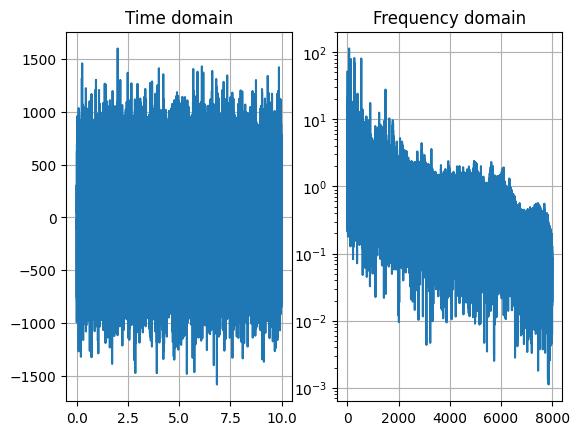

In [ ]:
#Test for 1 file the smoothing
i=1

N = norm_data[i].shape[0]
t_end = N / norm_sr[i]

x = np.linspace(0., t_end, N)
y = norm_data[i]

#Get the fft from the data
yf_v1 = fft(y)
yf = 2.0/N * np.abs(yf_v1[0:N//2])
xf = fftfreq(N, t_end/N)[:N//2]

plt.subplot(1,2,1)
plt.plot(x,y)
plt.grid()
plt.title('Time domain')

plt.subplot(1,2,2)
plt.plot(xf,yf)
plt.grid()
plt.yscale('log')
plt.title('Frequency domain')

plt.show()


In [12]:
#Perform smoothing for all data
anom_data_denoised = smoothen_fft(anom_data,anom_sr)
norm_data_denoised = smoothen_fft(norm_data,norm_sr)

[]

In [11]:
# extract mean, std, max, min, median, skewness, kurtosis, and energy

def extract_basics(data):
    means = []
    stds = []
    maxs = []
    mins = []
    medians = []

    for i in data:
        means.append(np.mean(i))
        stds.append(np.std(i))
        maxs.append(np.max(i))
        mins.append(np.min(i))
        medians.append(np.median(i))
        
    return means, stds, maxs, mins, medians

anom_means, anom_stds, anom_maxs, anom_mins, anom_medians = extract_basics(anom_data_denoised)
norm_means, norm_stds, norm_maxs, norm_mins, norm_medians = extract_basics(norm_data_denoised)

[]

In [9]:
# generate spectrogram

def spec(data):
    spectograms = []

    for i in data:
        x = librosa.stft(i)
        spectograms.append(librosa.amplitude_to_db(abs(x)))
        
    return spectograms

anom_spec = spec(anom_data_denoised)
norm_spec = spec(norm_data_denoised)
    
# plot first spectrogram
plt.figure(figsize=(15, 3))
librosa.display.specshow(anom_spec[0], sr=anom_sr, x_axis='time', y_axis='hz')
plt.title('Spectrogram')
plt.colorbar()

IndexError: list index out of range

<Figure size 1500x300 with 0 Axes>

In [13]:
# extract RMS

def rms(data):
    rms = []

    for i in data:
        S, phase = librosa.magphase(librosa.stft(i))
        rms.append(librosa.feature.rms(S=S))
        
    return rms

anom_rms = rms(anom_data_denoised)
norm_rms = rms(norm_data_denoised)

# plot first RMS
plt.figure(figsize=(15, 3))
plt.plot(anom_rms[0][0])
plt.title('Root-Mean-Square Energy')
plt.xlabel('Time (s)')
plt.ylabel('RMS')
plt.show()

IndexError: list index out of range

<Figure size 1500x300 with 0 Axes>

In [15]:
# extract ZCR

def zcr(data):
    zcr = []

    for i in data:
        zcr.append(librosa.feature.zero_crossing_rate(i))
        
    return zcr

anom_zcr = zcr(anom_data_denoised)
norm_zcr = zcr(norm_data_denoised)
    
# plot first ZCR
print(f"Zero crossing rate: {sum(librosa.zero_crossings(anom_data_denoised[0]))}")

plt.figure(figsize=(15, 3))
plt.plot(anom_zcr[0][0])
plt.title('Zero Crossing Rate')
plt.xlabel('Time (s)')
plt.ylabel('ZCR')
plt.show()

IndexError: list index out of range

In [16]:
# extract MFCC

def mfcc(data, sr):
    mfcc = []

    for i in data:
        mfcc.append(librosa.feature.mfcc(y=i, sr=sr))
        
    return mfcc

anom_mfcc = mfcc(anom_data_denoised, anom_sr)
norm_mfcc = mfcc(norm_data_denoised, norm_sr)

# plot first MFCC
plt.figure(figsize=(15, 3))
librosa.display.specshow(anom_mfcc[0], sr=anom_sr, x_axis='time')
plt.title('MFCC')
plt.xlabel('Time (s)')
plt.ylabel('MFCC')
plt.colorbar()
plt.show()

IndexError: list index out of range

<Figure size 1500x300 with 0 Axes>